In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

In [2]:
# first elem is top, last elem is bottom

default_mask = [
    'ah', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', 'th', 'jh', 'qh', 'kh',
    'ac', '2c', '3c', '4c', '5c', '6c', '7c', '8c', '9c', 'tc', 'jc', 'qc', 'kc',
    'ad', '2d', '3d', '4d', '5d', '6d', '7d', '8d', '9d', 'td', 'jd', 'qd', 'kd',
    'as', '2s', '3s', '4s', '5s', '6s', '7s', '8s', '9s', 'ts', 'js', 'qs', 'ks'
]

In [3]:
# Function to convert title into a valid Python variable name
def format_title(title):
    return title.strip().lower().replace(".", "_").replace(" ", "_")

# Read the content of the file
file_path = 'digitized_shuffles.txt'
with open(file_path, 'r') as file:
    lines = file.readlines()
    
current_title = ""
shuffles = {}

# Iterate over each line in the file
for line in lines:
    if line.strip().endswith(':'):
        # This is a title line
        current_title = format_title(line.strip()[:-1])
    elif line.strip() and current_title:
        # This is an item line corresponding to the current title
        items_list = [item.strip() for item in line.split(',')]
        shuffles[current_title] = items_list
        current_title = ""  # Reset current title for the next section

prettified_dict = {}
index = 0
for list_name, items_list in shuffles.items():
    prettified_dict[index] = items_list
    index += 1

prettified_dict[19];


In [4]:
def memoize(func):
    cache = {}
    def memoized_func(*args, **kwargs):
        args_key = tuple(tuple(arg) if isinstance(arg, list) else arg for arg in args) #tuples so hashable
        kwargs_key = tuple(sorted((key, tuple(value) if isinstance(value, list) else value) for key, value in kwargs.items()))
        key = (args_key, kwargs_key) 
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]
    return memoized_func

@memoize
def masked_order_dict(mask: list) -> dict:
    mask_dict = {}
    for index, value in enumerate(mask):
        mask_dict[value] = index
    return mask_dict

def masked_order(deck:list, mask:list=default_mask) -> list:
    assert set(deck) == set(default_mask), "All cards not found"
    mask_dict = masked_order_dict(mask)
    masked_deck = []
    for value in deck:
        masked_deck.append(mask_dict[value])
    return masked_deck

default_order = masked_order(default_mask)

In [5]:
fifty_two_card_probs = [scipy.special.comb(52, k) / (2**52) for k in range(0, 52 + 1)]

def binomial_random_number(n:int) -> int:
    # outputs a random number from [0, n] according to the binomial distribution
    # probabilities = [scipy.special.comb(n, k) / (2**n) for k in range(0, n + 1)]  #TODO: if computation slow, memoize probablities
    probabilities = fifty_two_card_probs
    assert sum(probabilities) == 1
    random_number = np.random.choice(range(0, n + 1), p=probabilities)
    return random_number

def GSR_shuffle(deck:list):
    #presume left pile is bottom (cut # cards) and right half is top (cut # cards are cut off)
    cut = binomial_random_number(52)
    right_deck = deck[:52-cut] #cut off binom cards
    left_deck = deck[52-cut:]
    assert len(left_deck) == cut, "left pile is not cut # cards"
    shuffled_deck = []
    while(left_deck or right_deck):
        num_cards_left = len(left_deck)
        num_cards_right = len(right_deck)
        p_left = num_cards_left / (num_cards_left + num_cards_right)
        select_left = np.random.choice(2, p=[1-p_left, p_left])
        if select_left:
            shuffled_deck.insert(0, left_deck.pop())
        else:
            shuffled_deck.insert(0, right_deck.pop())
    assert len(shuffled_deck) == 52, "uhhh"
    return shuffled_deck

GSR_shuffle(default_order);


In [6]:
def l2_loss_func(y, y_hat):
    loss = 0
    for index, value in enumerate(y):
        loss += (value - y_hat[index])**2
    return loss

def kldiv_loss_func(y, y_hat):
    loss = 0
    y = [x+1 for x in y] #to stop divide by zero, offset by 1
    y_hat = [x+1 for x in y_hat]
    for index, value in enumerate(y):
        loss += scipy.special.kl_div(value, y_hat[index])
    return loss

def spearman_rank_corr(y, y_hat):
    return scipy.stats.spearmanr(y, y_hat).statistic

def kendalls_tau(y, y_hat):
    return scipy.stats.kendalltau(y, y_hat).statistic

In [7]:
assert all(default_order == np.arange(52))
def risk(loss_func):
    G = []
    for _ in tqdm(range(10_000)):
        G.append(loss_func(default_order, GSR_shuffle(default_order)))

    U = []
    for _ in tqdm(range(10_000)):
        U.append(loss_func(default_order, random.sample(range(0, 52), 52)))

    E = []
    for i in tqdm(range(19)):
        E.append(loss_func(masked_order(prettified_dict[i], mask=prettified_dict[i]), masked_order(prettified_dict[i+1], mask=prettified_dict[i])))
    
    return G, U, E

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 6482.70it/s]


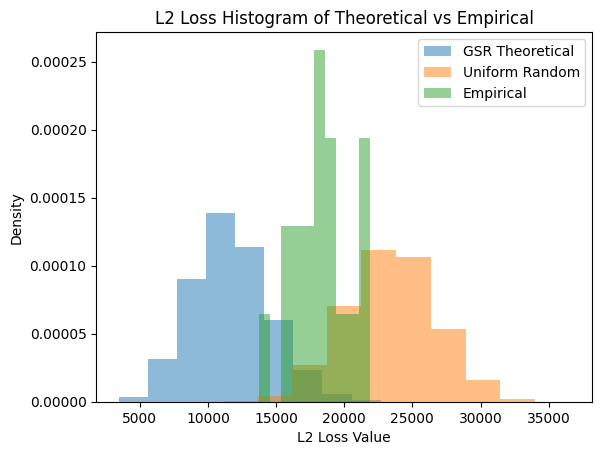

In [8]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(l2_loss_func)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel('L2 Loss Value')
plt.ylabel('Density')
plt.title('L2 Loss Histogram of Theoretical vs Empirical')
plt.legend(loc='best')
plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 19/19 [00:00<00:00, 3770.61it/s]


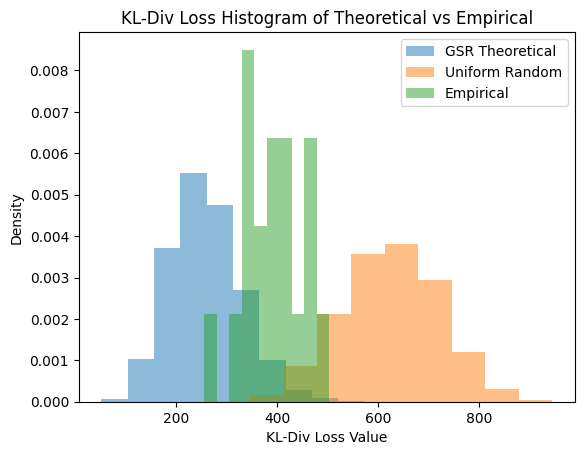

In [9]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(kldiv_loss_func)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel('KL-Div Loss Value')
plt.ylabel('Density')
plt.title('KL-Div Loss Histogram of Theoretical vs Empirical')
plt.legend(loc='best')
plt.show()

100%|██████████| 19/19 [00:00<00:00, 1160.60it/s]


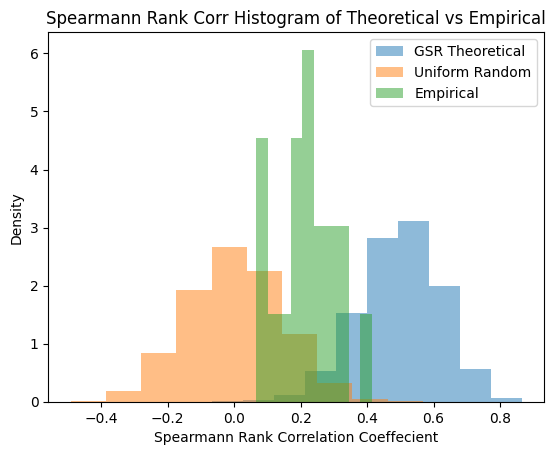

In [10]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(spearman_rank_corr)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel('Spearmann Rank Correlation Coeffecient')
plt.ylabel('Density')
plt.title('Spearmann Rank Corr Histogram of Theoretical vs Empirical')
plt.legend(loc='best')
plt.show()

100%|██████████| 19/19 [00:00<00:00, 907.36it/s]


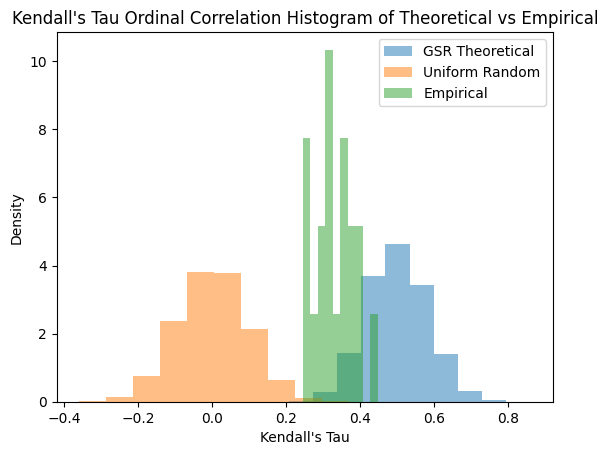

In [11]:
GSR_single_shuffle_simulated_loss, uniform_random_single_shuffle_simulated_loss, empirical_single_shuffle_simulated_loss = risk(kendalls_tau)
plt.hist(GSR_single_shuffle_simulated_loss, density=True, label="GSR Theoretical", alpha=0.5)
plt.hist(uniform_random_single_shuffle_simulated_loss, density=True, label="Uniform Random", alpha=0.5)
plt.hist(empirical_single_shuffle_simulated_loss, density=True, label="Empirical", alpha=0.5)
plt.xlabel("Kendall's Tau")
plt.ylabel('Density')
plt.title("Kendall's Tau Ordinal Correlation Histogram of Theoretical vs Empirical")
plt.legend(loc='best')
plt.show()